# Install Spark

Run the following code to install Spark in your local environment (this must be done only once)

1. **IMPORTANT**: Java JDK (version 8 or higher) must be installed in your machine.
2. Download Spark at [this link](https://archive.apache.org/dist/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz).
3. Run the next cell by changing the path to where you have downloaded the file above.

In [ ]:
!tar xf "C:\\Users\\Enrico\\Downloads\\spark-3.5.1-bin-hadoop3.tgz"
!pip install -q findspark

# Initialize Spark

Check the comments to change the paths to your Java and Spark homes (this must be done every time you run the notebook).

In [ ]:
import os
os.environ["JAVA_HOME"] = "C:\\Program Files\\Java\\jdk1.8.0_231" # Change this to the path of your JDK folder
os.environ["SPARK_HOME"] = "C:\\Users\\Enrico\\Downloads\\spark-3.5.1-bin-hadoop3" # Change this to the directory where you have extracted the .tgz file by running the command in the above cell
import findspark
findspark.init()
findspark.find() # Should return the directory of the Spark home

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()
sc = spark.sparkContext

sc

# Spark: working with RDDs

Check the documentation: [here](https://spark.apache.org/docs/latest/api/python/reference/pyspark.html#rdd-apis).

## Basics

In [ ]:
# let's create a simple example
riddle1 = "over the bench the sheep lives under the bench the sheep dies"
riddle2 = ["over the bench the sheep lives", "under the bench the sheep dies"]

In [ ]:
# create an RDD from the `riddle` string
rdd1 = sc.parallelize(riddle1.split(" "))
# each tuple of the RDD corresponds to a single word

print(rdd1)
# why is there no result returned?

In [ ]:
# compute the RDD
print(rdd1.collect())

In [ ]:
rdd2 = sc.parallelize(riddle2)
print(rdd2.collect())

## Transformations

In [ ]:
# map: returns a new RDD by applying a function to each of the elements in the original RDD
rdd1.map(lambda s: s.upper()).collect()

In [ ]:
# flatMap: returns a new RDD by applying the function to every element of the parent RDD and then flattening the result
rdd2.flatMap(lambda s: s.split(" ")).collect()

In [ ]:
# filter: returns a new RDD containing only the elements in the parent RDD that satisfy the function inside filter
rdd1.filter(lambda s: s.startswith("u")).collect()

In [ ]:
# distinct: returns a new RDD that contains only the distinct elements in the parent RDD
rdd1.distinct().collect()

In [ ]:
# groupByKey: groups the values for each key in the (key, value) pairs of the RDD into a single sequence
rdd1.map(lambda s: (s,1)).groupByKey().mapValues(list).collect()

# (first map converts to a key-value RDD)
# (mapValues is a map that operates only on the values - in this case, used to convert from ResultIterable to List for printing reasons)

In [ ]:
# reduceByKey: when called on a key-value RDD, returns a new dataset in which the values for each of its key are aggregated
rdd1.map(lambda s: (s,1)).reduceByKey(lambda x, y: x + y).collect()

In [ ]:
# sortByKey: returns a new RDD with (key,value) pairs of parent RDD in sorted order according to the key
rdd1.map(lambda s: (s,1)).sortByKey().collect()

In [ ]:
# join: starting from two RDD with (key, value1) and (key, value2) pairs, returns a new RDD with (key, (value1, value2)) pairs

# rddProvinces: (initials, name, region)
rddProvinces = sc.parallelize([("BO", "Bologna", "Emilia-Romagna"),("RA", "Ravenna", "Emilia-Romagna"),("MI", "Milan", "Lombardia")])
# rddPeople: (id, name, province)
rddPeople = sc.parallelize([(1, "Enrico", "RA"),(2, "Alice", "RA"),(3, "Bob", "BO"),(4, "Charlie", "FC")])

# This does not work
rddPeople.join(rddProvinces).collect()

In [ ]:
rddProvinces2 = rddProvinces.map(lambda p: (p[0], (p[1],p[2])))
rddProvinces2.collect()

In [ ]:
rddPeople2 = rddPeople.map(lambda p: (p[2], (p[0],p[1])))
rddPeople2.collect()

In [ ]:
rddPeople2.join(rddProvinces2).collect()

## Actions

In [ ]:
# collect: returns a list that contains all the elements of the RDD
rdd1.collect()

In [ ]:
# count: returns the number of elements in the RDD
rdd1.count()

In [ ]:
# reduce: aggregates the elements of the RDD using a function that takes two elements of the RDD as input and gives the result
sc.parallelize([1, 2, 3, 4, 5]).reduce( lambda x, y: x * y)

In [ ]:
# take: returns the first n elements of RDD in the same order
rdd1.take(2)

In [ ]:
# saveAsTextFile: saves the content of the RDD to a file
rdd1.saveAsTextFile("rdd1")

## Examples

In [ ]:
# Flatten the words beginning with the letter C
# - map: transform each string in upper case (remember: map returns a new RDD with the same cardinality)
# - filter: keep only the strings beginning with "C" (remember: filter returns a new RDD with the same or smaller cardinality)
# - flatMap: explode each string into its characters (remember: flatMap returns a new RDD with the any cardinality)
rdd1\
    .map(lambda s: s.upper())\
    .filter(lambda s: s.startswith("U"))\
    .flatMap(lambda s: list(s))\
    .collect()

In [ ]:
# A simple word count
# - map: map each word to a tuple (word, 1); each tuple represent the count associate with a word
# - reduceByKey: group all the tuples with the same word and sum the counts
# - sortBy: sort tuples by count
rdd1\
    .map(lambda s: (s, 1))\
    .reduceByKey(lambda a, b: a + b)\
    .sortBy(lambda x: x[1], False)\
    .collect()

In [ ]:
# Compute average length of words depending on their initial letter
# map: map each word to a key-value tuple (word, (wordLength, 1)), where the value is an object composed by two value: the length of the word and a 1
# reduceByKey: group all the tuples with the same word to 1) sum the lengths, and 2) sum the counts
# mapValues: divides the sums by the counts to compute the averages
# sortBy: sort tuples by averages
rdd1\
  .map(lambda s: (s[0], (len(s),1)))\
  .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))\
  .mapValues(lambda x: x[0]/x[1])\
  .sortBy(lambda x: x[1], False)\
  .collect()

# Spark: working with DataFrames

Check the documentation: [here](https://spark.apache.org/docs/3.2.1/api/python/reference/api/pyspark.sql.DataFrame.html).

What is different from Pandas' DataFrames?

- Spark supports parallelization (Pandas doesn't), thus it's more suitable for big data processing
- Spark follows Lazy Execution, which means that a task is not executed until an action is performed (Pandas follows Eager Execution, which means task is executed immediately)
- Spark has immutability (Pandas has mutability)
- The data structure is similar, the APIs are different

In [ ]:
df = spark.read.option("delimiter", ",").option("header", "true").csv("../datasets/housing.csv")
df.show()

In [ ]:
# Switching from Spark to Pandas
pandasDF = df.toPandas()
print(pandasDF)

In [ ]:
# Switching from Pandas to Spark
df = spark.createDataFrame(pandasDF)
df.show()

In [ ]:
# select: returns a new DataFrame with only selected columns (similar to a map on RDDs)
df.select('population','median_house_value').show()

In [ ]:
# select, similarly to a map, allows column values to be redefined
df.select(df.population,df.median_house_value/1000).show()
# put the operation within parenthesis and add .alias('median_house_value_in_K$')

In [ ]:
# withColumn: used to manipulate (rename, change the value, convert the datatype)
# an existing column in a dataframe (or to create a new column) while keeping the rest intact
df.withColumn('median_house_value_in_K$',df.median_house_value/1000).show()

In [ ]:
# filter: returns a new DataFrame containing only the elements in the parent DataFrame that satisfy the function inside filter (as in RDDs)
# orderBY: orders the DataFrame by the selected column(s)
df.filter(df.population > 1000).orderBy(df.population.asc()).show()

In [ ]:
# groupBy: returns a new DataFrame which is the result of an aggregation
df.groupBy(df.ocean_proximity).agg({'median_house_value': 'avg', '*': 'count'}).show()

In [ ]:
# withColumnRenamed: rename a column
df.groupBy(df.ocean_proximity).agg({'*': 'count'}).withColumnRenamed("count(1)", "tot").show()

In [ ]:
# SQL queries can be run on a DataFrame
df.createOrReplaceTempView("housing")
spark.sql("select ocean_proximity, avg(median_house_value) as avg_price from housing group by ocean_proximity order by avg_price desc").show()

# Exercise: creating a cube

You are working with two files:

- weather-stations.csv: it contains a list of weather stations that capture weather information every day of every year throughout the world
  - Each station is identified by a StationID
- weather-sample-10k.csv: it contains the data measured by a certain station on a certain date (a sample of 10k lines collected from the National Climatic Data Center of the USA)
  - Each weather measurenent is identified by a StationID and a Timestamp

Your goal is to create a single file representing the following cube and to run some queries through PowerBI.

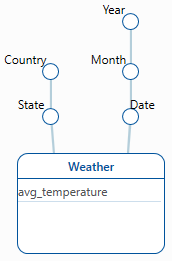

The procedure to create the cube is the following.

1. On the stations file:
  1. replace empty states and countries in stations with a placeholder value (e.g., "XX");
  1. keep only the following fields: stationId, state, country
2. On the weather-sample file:
  1. filter out weather wrong measurements (i.e., where airTemperatureQuality=9);
  1. keep only the following fields: stationId, airTemperature, date, month, year
  1. create a new fulldate field by concatenating year, month, and date
  1. create a new fullmonth field by concatenating year and month
1. Join stations with weather measurements on the stationId field
1. Keep only the following fields: state, country, fulldate, fullmonth, year, airTemperature
1. Aggregate the measurements by state and date to take the average temperature
  - Group by: state, country, fulldate, fullmonth, year
  - Calculation: avg(airTemperature)
1. Save the result on a file

## Spark

In [ ]:
dfW = sc.textFile("../datasets/weather-sample-10k.txt")\
  .map(lambda l: (l[4:15],l[15:19],l[19:21],l[21:23],int(l[87:92])/10,l[92:93]))\
  .toDF(["stationId","year","month","day","airTemperature","airTemperatureQuality"])
dfW.show()

In [ ]:
from pyspark.sql.functions import concat
dfS = spark.read.option("delimiter", ",").option("header", "false").csv("../datasets/weather-stations.csv")
dfS = dfS.select(concat(dfS[0],dfS[1]),dfS[2],dfS[3],dfS[4],dfS[5],dfS[6],dfS[7],dfS[8],dfS[9],dfS[10])\
  .toDF("stationId","city","country","state","call","latitude","longitude","elevation","date_begin","date_end")
dfS.show()

1. On the stations file:
  1. replace empty states and countries in stations with a placeholder value (e.g., "XX");
  1. keep only the following fields: stationId, state, country

In [ ]:
dfS1 = dfS.fillna({'state': 'XX', 'country':'XX'})
dfS2 = dfS1.select('stationId','state','country')
dfS2.show()

2. On the weather-sample file:
  1. filter out weather wrong measurements (i.e., where airTemperatureQuality=9);
  1. keep only the following fields: stationId, airTemperature, date, month, year
  1. create a new fulldate field by concatenating year, month, and date
  1. create a new fullmonth field by concatenating year and month

In [ ]:
from pyspark.sql.functions import concat, lit
dfW1 = dfW.where("airTemperature < 9")
dfW2 = dfW1.select('stationId','airTemperature','day','month','year')
dfW3 = dfW2.withColumn("fulldate", concat(dfW1.year,lit("-"),dfW1.month,lit("-"),dfW1.day))
dfW4 = dfW3.withColumn("fullmonth", concat(dfW1.year,lit("-"),dfW1.month))
dfW4.show()

3. Join stations with weather measurements on the stationId field


In [ ]:
dfJ = dfS2.join(dfW4, "stationId")
dfJ.show()

4. Keep only the following fields: state, country, fulldate, fullmonth, year, airTemperature

In [ ]:
dfJ2 = dfJ.select("state", "country", "fulldate", "fullmonth", "year", "airTemperature")
dfJ2.show()

5. Aggregate the measurements by state, country and date to take the average temperature
  - Group by: state, country, fulldate, fullmonth, year
  - Calculation: avg(airTemperature)

In [ ]:
dfG = dfJ2.groupBy("state", "country", "fulldate", "fullmonth", "year").agg({'airTemperature': 'avg'})
dfG.show()

6. Save the result on a file

In [ ]:
dfG.write.mode('overwrite').option('header','true').csv("weather-cube")

## PowerBI

Download the file from the left panel of this notebook (in case of issues, download it from [here](https://raw.githubusercontent.com/w4bo/2024-bbs-dm/master/materials/results/weather-cube.csv)) and load it in [Power BI](https://app.powerbi.com/).
- Visualize the daily trend of average temperatures for each country
- Show the average temperature on the map


The final Power BI file will be available [here](https://raw.githubusercontent.com/w4bo/2024-bbs-dm/master/materials/results/weather-cube.pbix).

# Additional exercises

The solution will be available [here](https://raw.githubusercontent.com/w4bo/2024-bbs-dm/master/materials/results/2024_bbs_dm_spark_basics_solution.ipynb).

## Getting familiar with data frame transformations

Carry out the following operations (in any order).

- ```.select()``` operator; starting from ```dfS```:
  1. keep only country, elevation, date_begin, and date_end
  1. keep only the first four characters of date_begin using [sf.substring](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.substring.html)
  1. use [concat](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.concat.html) to concatenate date_begin with date_end and putting an underscore (\_) in the middle; since the underscore is not a column, declare it as ```sf.lit("_")```
  1. use [coalesce](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.coalesce.html) to take the value of country if not null, otherwise the value of city
  1. put countries in lowercase using [sf.lower](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.lower.html)
  1. in the previous four points, use ```.alias()``` to give a meaningful name to the obtained columns
- ```.withColumn()``` operator; starting from ```dfS```:
  1. do the same as points 2 to 5 of the ```select``` operator, but using ```withColumn```
- ```.filter()``` operator; starting from ```dfS```, keep only the rows where:
  1. elevation is greater than 5000
  1. country is not null, using [sf.isnotnull](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.isnotnull.html)
  1. conditions 1 and 2 are both true; conditions must be put between parenthesis and separated by "&" (e.g., check [here](https://www.geeksforgeeks.org/pyspark-filter-dataframe-based-on-multiple-conditions/))
  1. either one of conditions 1 and 2 is true; conditions must be put between parenthesis and separated by "|" (e.g., check [here](https://www.geeksforgeeks.org/pyspark-filter-dataframe-based-on-multiple-conditions/))
  1. date_begin is the first day of the month (requires to use substring)
- ```.groupBy()``` operator; starting from ```dfW```:
  1. group by airTemperatureQuality to count how many rows there are for each value
  1. as above, but also calculate the average temperature
  1. as above, but also given meaningful names to the results using ```withColumnRenamed```
  1. group by month to calculate the minimum and maximum temperatures and order by month using ```orderby```; to aggregate differently on the same column, use the [sf.max](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.max.html) and [sf.min](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.min.html) functions inside the ```agg``` function instead of the object enclosed by brackets ```{}```
  1. group by month and day to calculate the minimum and maximum temperatures
  1. group by stationId and year month to count the number of rows

In [ ]:
import pyspark.sql.functions as sf

# SELECT

# dfS.select("country", "elevation", "date_begin", "date_end").show()
# dfS.select(sf.substring(dfS.date_begin,0,4).alias("substringing")).show()
# dfS.select(concat(dfS.date_begin,sf.lit("_"),dfS.date_end).alias("concatenating")).show()
# dfS.select(sf.coalesce(dfS.country, dfS.city).alias("coalescing")).show()
# dfS.select(sf.lower(dfS.country).alias("lowercasing")).show()

# WITH_COLUMN

# dfS.withColumn("substringing",sf.substring(dfS.date_begin,1,4)).show()
# dfS.withColumn("concatenating",concat(dfS.date_begin,sf.lit("_"),dfS.date_end)).show()
# dfS.withColumn("coalescing",sf.coalesce(dfS.country, dfS.city)).show()
# dfS.withColumn("lowercasing",sf.lower(dfS.country)).show()

# FILTER

# dfS.filter(dfS.elevation>5000).show()
# dfS.filter(sf.isnotnull(dfS.country)).show()
# dfS.filter((sf.isnotnull(dfS.country)) & (dfS.elevation>5000)).show()
# dfS.filter((sf.isnotnull(dfS.country)) | (dfS.elevation>5000)).show()
# dfS.filter(sf.substring(dfS.date_begin,7,2)=="01").show()

# GROUP BY

# dfW.groupBy(dfW.airTemperatureQuality).agg({'*': 'count'}).show()
# dfW.groupBy(dfW.airTemperatureQuality).agg({'*': 'count', 'airTemperature': 'avg'}).show()
# dfW.groupBy(dfW.airTemperatureQuality).agg({'*': 'count', 'airTemperature': 'avg'}).withColumnRenamed('avg(airTemperature)','avg-temperature').withColumnRenamed('count(1)','cnt').show()
# dfW.groupBy(dfW.month).agg(sf.min(dfW.airTemperature),sf.max(dfW.airTemperature)).orderBy(dfW.month).show()
# dfW.groupBy(dfW.month,dfW.day).agg(sf.min(dfW.airTemperature),sf.max(dfW.airTemperature)).show()
# dfW.groupBy(dfW.stationId,dfW.year).agg({'*': 'count'}).show()

## Complete exercises

Carry out the following exercises (in any order).

- Check if there exist stations with a negative elevation; then, calculate how many of these stations exist in each country; rename the result to "cnt" and order the result by decreasing cnt
- Take only stations with positive elevation, compute the maximum elevation by country and rename the result to "elevation"; then, join the result with the original dfS to get, for each country, the name of the city with the highest elevation (join key: ```["country","elevation"]```); order the result by decreasing elevation
- Take only weather values with airQuality==1, compute the minimum temperature for each stationId and rename it to "minTemperature"; then, join the result with dfS and keep only the columns "minTemperature" and "elevation"; finally, use the correlation between the two columns. To do the last part, you need to:
  - cast the elevation to an integer datatype: you need to add ```from pyspark.sql.types import IntegerType``` and then ```df.myfield.cast(IntegerType())```;
  - compute the correlation with ```df.stat.corr("myfield1","myfield2")```.

In [ ]:
dfS3 = dfS.filter(dfS.elevation<0).groupBy(dfS.country).agg({'*': 'count'}).withColumnRenamed('count(1)','cnt')
dfS3.orderBy(dfS3.cnt.desc()).show()

In [ ]:
dfS4 = dfS.filter(dfS.elevation>=0).groupBy(dfS.country).agg({'elevation': 'max'}).withColumnRenamed('max(elevation)','elevation')
dfS4.join(dfS,["country","elevation"]).orderBy(dfS4.elevation.desc()).show()

In [ ]:
from pyspark.sql.types import IntegerType
dfW5 = dfW.filter(dfW.airTemperatureQuality==1).groupBy(dfW.stationId).agg({'airTemperature': 'min'}).withColumnRenamed('min(airTemperature)','minTemperature')
dfW6 = dfW5.join(dfS,"stationId").select("minTemperature","elevation")
dfW7 = dfW6.withColumn("elevation",dfW6.elevation.cast(IntegerType()))
dfW7.stat.corr("minTemperature","elevation")
dfW7.show()